## Callin Switzer
## Try to follow a trajectory, based on nnet

In [19]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import os
import pandas as pd
import time
from datetime import datetime
import sys
import csv
import seaborn as sns
sns.set(style="ticks")
import scipy.io
import subprocess
import csv
import pickle
pd.set_option('display.max_columns', 500)

import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")

print(sys.version, "\n")

now = datetime.now()
print("last run on " + str(now))

#%qtconsole

# define directories
baseDir = os.getcwd()
dataDir = r'D:\MothSimulations\11c-AggressiveManeuver\Qstore\hws_am_con'
figDir = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\Figs'
dataOutput = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\DataOutput'
savedModels = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\savedModels'
randomRawData = r'D:/Dropbox/AcademiaDropbox/mothMachineLearning_dataAndFigs/PythonGeneratedData'

if not os.path.exists(dataOutput):
    os.mkdir(dataOutput)
if not os.path.exists(savedModels):
    os.mkdir(savedModels)
    
# open file explorer
# aa = r'explorer /select,"'
# subprocess.Popen(str(aa + figDir + '\"'))
# subprocess.Popen(str(aa + dataDir + '\"'))

TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.
3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)] 

last run on 2019-01-02 14:14:11.998375


In [20]:
# import custom Utils functions
from DeepLearningUtils import *

In [21]:
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import regularizers

# Keras callcacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

In [22]:
# functions for calculating angle
# calculate alpha
def quadrant(Fx, Fy):
    if (Fx >= 0) & (Fy >= 0):
        q = 1
    elif (Fx < 0) & (Fy >= 0):
        q = 2
    elif (Fx < 0) & (Fy < 0):
        q = 3
    elif (Fx >= 0) & (Fy < 0):
        q = 4
    else:
        q = 999999
    return(q)

def angleCalc(Fx, Fy, q):
    fx = np.abs(Fx)
    fy = np.abs(Fy)
    
    if q == 1:
        alpha = np.arctan(fy/fx)
    elif q == 2:
        alpha = np.pi - np.arctan(fy/fx)
    elif q == 3: 
        alpha = np.pi + np.arctan(fy/fx)
    elif q == 4:
        alpha = (2*np.pi) - np.arctan(fy/fx)
    return(alpha)

In [23]:
# Load model
K.clear_session()
from keras.models import load_model
model = load_model(os.path.join(savedModels, 'my_model_400Units_noZeros.h5'))

In [24]:
# Generate path to follow
# 2 Hz sine wave, points 0.02 sec apart
tsteps = np.linspace(0, 2*2, num = 201)
sig = 10 * np.sin(2*np.pi* 2*tsteps)
#tsteps

In [25]:
# load dataset -- then change values
predDF = pd.read_csv(os.path.join(dataOutput, "NNpreds_small_RandomICs.csv")).iloc[0:len(tsteps), :]

In [26]:
print(predDF.shape)
predDF.head()

(201, 19)


,x_0,y_0,phi_0,theta_0,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0,F_pred,alpha_pred,tau_pred,x_99,y_99,phi_99,theta_99,x_dot_99_pred,y_dot_99_pred,phi_dot_99_pred,theta_dot_99_pred
0,0.0,0.0,5.717836,2.903536,1140.923218,-399.095208,-20.919668,7.162696,5242.905,0.227884,87642.836,21.425903,-8.116010,5.438490,2.756136,966.60364,-434.46356,-11.772325,-5.640531
1,0.0,0.0,3.799657,4.295602,1216.867455,1286.049934,9.030914,5.734873,21598.404,2.597742,-67889.390,27.849758,27.358930,3.870090,4.277221,1548.62660,1466.32930,-1.445739,-6.679240
2,0.0,0.0,1.426920,3.170749,1008.157261,175.219341,-19.672703,-17.241171,23363.543,1.863295,-15468.784,20.439296,-0.898106,1.004533,2.738070,1000.94440,-266.57200,-23.733850,-25.134838
3,0.0,0.0,1.401717,4.076364,-1022.919335,-980.612881,-9.282598,-20.555771,32194.880,3.678808,68082.640,-19.039632,-13.359467,1.199188,3.981795,-955.95240,-369.71906,-4.945975,0.057465
4,0.0,0.0,0.350069,5.063611,827.387703,1371.685241,2.420546,-2.941864,15569.313,3.173099,-8812.373,15.881660,29.669649,0.238542,4.952067,745.15857,1623.83780,-10.901551,-11.416786


In [27]:
predDF.x_99 = 0
predDF.y_99 = np.hstack([np.diff(sig), 9999])
predDF.phi_0 = 3.926991
predDF.phi_99 = 3.926991

predDF.theta_0 = 0.785398
predDF.theta_99 = 0.785398


predDF[["F_pred", "alpha_pred", "tau_pred", 
        "x_dot_99_pred", "y_dot_99_pred", "phi_dot_99_pred", "theta_dot_99_pred", 
       "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]] = (np.zeros([len(tsteps), 11]) + 1)*999

predDF.y_dot_0 = 40 * np.pi * np.cos(4*np.pi*tsteps)
predDF.phi_dot_0 =0
predDF.theta_dot_0 = 0
predDF.x_dot_0 = 0.000001


predDF["Fx_pred"], predDF["Fy_pred"] = 999,999

#predDF.loc[0, ["x_dot_0", "phi_dot_0", "theta_dot_0"]] = np.array([0.0001, 0.0001, 0.0001])



In [28]:
predDF.head()

,x_0,y_0,phi_0,theta_0,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0,F_pred,alpha_pred,tau_pred,x_99,y_99,phi_99,theta_99,x_dot_99_pred,y_dot_99_pred,phi_dot_99_pred,theta_dot_99_pred,Fx_pred,Fy_pred
0,0.0,0.0,3.926991,0.785398,0.000001,125.663706,0,0,999.0,999.0,999.0,0,2.486899,3.926991,0.785398,999.0,999.0,999.0,999.0,999,999
1,0.0,0.0,3.926991,0.785398,0.000001,121.715750,0,0,999.0,999.0,999.0,0,2.330638,3.926991,0.785398,999.0,999.0,999.0,999.0,999,999
2,0.0,0.0,3.926991,0.785398,0.000001,110.119945,0,0,999.0,999.0,999.0,0,2.027934,3.926991,0.785398,999.0,999.0,999.0,999.0,999,999
3,0.0,0.0,3.926991,0.785398,0.000001,91.604899,0,0,999.0,999.0,999.0,0,1.597808,3.926991,0.785398,999.0,999.0,999.0,999.0,999,999
4,0.0,0.0,3.926991,0.785398,0.000001,67.333981,0,0,999.0,999.0,999.0,0,1.067286,3.926991,0.785398,999.0,999.0,999.0,999.0,999,999


In [29]:
# scale data for nnet predictions
X = predDF.loc[:, ["phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

# scale data
scalerfileX = 'scalerX.pkl'
scalerfileY = 'scalerY.pkl'

scalerX = pickle.load(open(os.path.join(dataOutput, scalerfileX), 'rb'))
X_scaled = scalerX.transform(X)

scalerY = pickle.load(open(os.path.join(dataOutput, scalerfileY), 'rb'))

In [30]:
pd.DataFrame(X_scaled, columns = X.columns).head()

,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,0.125,-0.375,0.001001,0.035840,0.091186,-0.267706,-3.508074e-07,0.041888,-1.335214e-07,3.328530e-08
1,0.125,-0.375,0.001001,0.033795,0.091186,-0.267706,-3.508074e-07,0.040572,-1.335214e-07,3.328530e-08
2,0.125,-0.375,0.001001,0.029835,0.091186,-0.267706,-3.508074e-07,0.036707,-1.335214e-07,3.328530e-08
3,0.125,-0.375,0.001001,0.024207,0.091186,-0.267706,-3.508074e-07,0.030535,-1.335214e-07,3.328530e-08
4,0.125,-0.375,0.001001,0.017265,0.091186,-0.267706,-3.508074e-07,0.022445,-1.335214e-07,3.328530e-08


In [31]:
# loop to predict
for ii in range(len(tsteps)):
    scaledPreds = model.predict(X_scaled[ii, ].reshape(1, -1))
    predDF.loc[ii, ["Fx_pred", "Fy_pred", "tau_pred", "x_dot_99_pred", "y_dot_99_pred", 
                        "phi_dot_99_pred", "theta_dot_99_pred"] ] = scalerY.inverse_transform(scaledPreds)[0, :]

# this puts the new derivatives in
#     predDF.loc[ii+1, ["x_dot_0", "y_dot_0", 
#                         "phi_dot_0", "theta_dot_0"] ] = np.array(predDF.loc[ii, ["x_dot_99_pred", "y_dot_99_pred", "phi_dot_99_pred", "theta_dot_99_pred"] ])




In [32]:
predDF.tail()

,x_0,y_0,phi_0,theta_0,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0,F_pred,alpha_pred,tau_pred,x_99,y_99,phi_99,theta_99,x_dot_99_pred,y_dot_99_pred,phi_dot_99_pred,theta_dot_99_pred,Fx_pred,Fy_pred
196,0.0,0.0,3.926991,0.785398,0.000001,67.333981,0,0,999.0,999.0,-350.035431,0,1.597808,3.926991,0.785398,-22.332081,139.266647,-0.165872,-0.268434,1500.899780,2315.257812
197,0.0,0.0,3.926991,0.785398,0.000001,91.604899,0,0,999.0,999.0,-321.274933,0,2.027934,3.926991,0.785398,-22.207941,159.611984,-0.174110,-0.271921,1336.405273,2119.616699
198,0.0,0.0,3.926991,0.785398,0.000001,110.119945,0,0,999.0,999.0,-306.486115,0,2.330638,3.926991,0.785398,-22.133829,172.478394,-0.181177,-0.274251,1126.290527,1872.670410
199,0.0,0.0,3.926991,0.785398,0.000001,121.715750,0,0,999.0,999.0,-306.682068,0,2.486899,3.926991,0.785398,-22.110157,177.063324,-0.186556,-0.275331,883.826111,1590.065796
200,0.0,0.0,3.926991,0.785398,0.000001,125.663706,0,0,999.0,999.0,84393.335938,0,9999.000000,3.926991,0.785398,-652.462585,-243.947510,-21.159119,-14.819510,41855.582031,30744.150391


In [33]:
predDF = predDF.iloc[:-1, :]

In [34]:
# convert to F, alpha, tau
predDF["F_pred"] = np.sqrt(predDF["Fx_pred"]**2 + predDF["Fy_pred"]**2)
predDF["quadrant"] = [quadrant(fx, fy) for fx,fy in zip(predDF["Fx_pred"], predDF["Fy_pred"])]
predDF["alpha_pred"] = [angleCalc(fx, fy, q) for fx, fy, q in zip(predDF["Fx_pred"], predDF["Fy_pred"], predDF["quadrant"])]
predDF["tsteps"] = tsteps[0:len(predDF)]
predDF.head(20)

,x_0,y_0,phi_0,theta_0,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0,F_pred,alpha_pred,tau_pred,x_99,y_99,phi_99,theta_99,x_dot_99_pred,y_dot_99_pred,phi_dot_99_pred,theta_dot_99_pred,Fx_pred,Fy_pred,quadrant,tsteps
0,0.0,0.0,3.926991,0.785398,0.000001,125.663706,0,0,1432.744547,1.119976,-321.818451,0,2.486899,3.926991,0.785398,-22.135920,173.082687,-0.189894,-0.275100,624.252136,1289.599243,1,0.00
1,0.0,0.0,3.926991,0.785398,0.000001,121.715750,0,0,1054.857548,1.218496,-350.956696,0,2.330638,3.926991,0.785398,-22.208017,160.787750,-0.190977,-0.273578,363.986359,990.069885,1,0.02
2,0.0,0.0,3.926991,0.785398,0.000001,110.119945,0,0,720.155435,1.404157,-392.329529,0,2.027934,3.926991,0.785398,-22.322237,140.949417,-0.189717,-0.270872,119.451866,710.179626,1,0.04
3,0.0,0.0,3.926991,0.785398,0.000001,91.604899,0,0,476.758957,1.769239,-443.292358,0,1.597808,3.926991,0.785398,-22.474615,114.808495,-0.186243,-0.267093,-93.989716,467.402435,2,0.06
4,0.0,0.0,3.926991,0.785398,0.000001,67.333981,0,0,381.768676,2.330324,-500.684509,0,1.067286,3.926991,0.785398,-22.657322,84.003555,-0.180822,-0.262525,-262.877808,276.843964,2,0.08
5,0.0,0.0,3.926991,0.785398,0.000001,38.832221,0,0,405.534236,2.761651,-560.827393,0,0.469702,3.926991,0.785398,-22.863537,50.467232,-0.173815,-0.257357,-376.614044,150.399063,2,0.10
6,0.0,0.0,3.926991,0.785398,0.000001,7.890489,0,0,438.734461,2.921035,-619.975403,0,-0.157395,3.926991,0.785398,-23.082127,16.308725,-0.165748,-0.251988,-428.106384,95.983597,2,0.12
7,0.0,0.0,3.926991,0.785398,0.000001,-23.547030,0,0,430.401830,2.866178,-674.361633,0,-0.774602,3.926991,0.785398,-23.302217,-16.320671,-0.157096,-0.246662,-414.181122,117.045860,2,0.14
8,0.0,0.0,3.926991,0.785398,0.000001,-53.505004,0,0,397.277617,2.577732,-720.575256,0,-1.343138,3.926991,0.785398,-23.508957,-45.365654,-0.148443,-0.241785,-335.778198,212.326416,2,0.16
9,0.0,0.0,3.926991,0.785398,0.000001,-80.101061,0,0,424.774265,2.055452,-755.731750,0,-1.827280,3.926991,0.785398,-23.688747,-68.998276,-0.140259,-0.237618,-197.903793,375.855377,2,0.18


In [35]:
# save df
# save predicted DF
predDF.to_csv(os.path.join(dataOutput, "PredictedTraj2_feed.csv"), index = False)

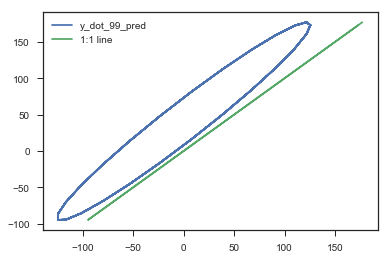

In [36]:
plt.plot(predDF.y_dot_0, predDF.y_dot_99_pred)
plt.plot(predDF.y_dot_99_pred, predDF.y_dot_99_pred, label  = "1:1 line")
plt.legend()

In [ ]:
# Predict steps with nnet (without feedback)
x_0 = np.repeat(0, len(tsteps))
x_f = x_0.copy()
y_0 = x_0.copy()
y_error = np.hstack([np.nan, np.diff(sig)])
theta_0 = np.repeat(0.785398, len(tsteps))
phi_0 = np.repeat(3.926991, len(tsteps))
x_dot_0 = np.repeat(0.0001, len(tsteps))
y_dot_0 = np.repeat(0.0001, len(tsteps))
phi_dot_0 = np.repeat(0.0001, len(tsteps))
theta_dot_0 = np.repeat(0.0001, len(tsteps))
Fx = np.repeat(0, len(tsteps))
Fy = np.repeat(0, len(tsteps))
tau = np.repeat(0, len(tsteps))


predDF = pd.DataFrame(np.transpose(np.array([tsteps, 
                                             sig, 
                                             x_0,
                                             x_f,
                                             y_0,
                                             y_error,
                                             theta_0,
                                             theta_0,
                                             phi_0, 
                                             phi_0, 
                                             x_dot_0, 
                                             y_dot_0, 
                                             phi_dot_0, 
                                             theta_dot_0, 
                                             Fx, 
                                             Fy, 
                                             tau
                                            ])), 
                     columns=["tsteps", "signal", "x_0", "x_99", "y_0", "y_99", 
                             "theta_0", "theta_99", "phi_0", "phi_99", 
                             "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0", 
                             "Fx", "Fy", "tau_pred"])



predDF["x_99_actual"] = 0
predDF["xd_99_actual"] = 0
predDF["y_99_actual"] = 0
predDF["yd_99_actual"] = 0

predDF["theta_99_actual"] = 0
predDF["thetad_99_actual"] = 0

predDF["phi_99_actual"] = 0
predDF["phid_99_actual"] = 0

predDF["F_pred"] = 0
predDF["alpha_pred"] = 0


pd.set_option('display.max_columns', 500)
predDF.head()

# X = testDF.loc[:, ["x_0", "y_0", "phi_0", "theta_0", 
#                     "x_99", "y_99", "phi_99", "theta_99", 
#                    "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

In [ ]:
# scale data for nnet predictions
X = predDF.loc[1:, ["x_0", "y_0", "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

# scale data
scalerfileX = 'scalerX.pkl'
scalerfileY = 'scalerY.pkl'

scalerX = pickle.load(open(os.path.join(dataOutput, scalerfileX), 'rb'))
X_scaled = scalerX.transform(X)

scalerY = pickle.load(open(os.path.join(dataOutput, scalerfileY), 'rb'))

In [ ]:
# Predict steps with nnet, and reset at actual value (from simulation)
for ii in range(1, len(tsteps)-1):
    nnpreds = model.predict(X_scaled[ii, :].reshape(-1,12))
    nnpreds_unscaled = scalerY.inverse_transform(nnpreds)

    # Y = testDF.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
    #                    "phi_dot_99", "theta_dot_99"] ]
    
   
    # put predictions back into data frame
    predDF.loc[ii + 1, ["x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]] = nnpreds_unscaled[0, [3,4,5,6]]
    predDF.loc[ii, ["Fx", "Fy", "tau_pred"]] = nnpreds_unscaled[0, [0,1,2]]
    
    X = predDF.loc[1:, ["x_0", "y_0", "phi_0", "theta_0", 
                "x_99", "y_99", "phi_99", "theta_99", 
               "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]
    X_scaled = scalerX.transform(X)
    

In [ ]:
# convert to F, alpha, tau
predDF["F_pred"] = np.sqrt(predDF["Fx"]**2 + predDF["Fy"]**2)
predDF["quadrant"] = [quadrant(fx, fy) for fx,fy in zip(predDF["Fx"], predDF["Fy"])]
predDF["alpha_pred"] = [angleCalc(fx, fy, q) for fx, fy, q in zip(predDF["Fx"], predDF["Fy"], predDF["quadrant"])]

predDF.head()

In [ ]:
plt.plot(predDF.y_99)

In [ ]:
# save predicted DF
predDF.to_csv(os.path.join(dataOutput, "PredictedTraj2.csv"), index = False)


In [ ]:
predDF.iloc[1, :]

In [ ]:
trainDF2 = pd.read_csv(os.path.join(dataDir2, "smallDF.csv"))
trainDF2.head()

In [ ]:
# make dataset
indexCut = int(0.9 * trainDF2.shape[0])
trainDF2["Test_Set"] = trainDF2.index > indexCut

# refref: add dots as output

X = trainDF2.loc[0:indexCut-1, ["x_0", "y_0", "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Y = trainDF2.loc[0:indexCut-1, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

# # # subtract x_0 and y_0 from everything
# X.x_99 = X.x_99 - X.x_0
# X.y_99 = X.y_99 - X.y_0

# X.x_0 = X.y_0 = 0

In [ ]:
# plot range of initial conditions (scatterplot matrix)
sns.pairplot(trainDF2.loc[:, ["x_0", "y_0", "phi_0", "theta_0", "Test_Set"]].drop_duplicates(), 
             vars = ["x_0", "y_0", "phi_0", "theta_0"], 
             hue = "Test_Set", diag_kind = 'kde', 
            palette = 'viridis', plot_kws=dict(alpha = 0.5, s = 20, edgecolor="grey", linewidth=0))
plt.savefig(os.path.join(figDir, "TrainingVSTestConditions.png"), width = 10, height = 10, dpi = 120)

In [ ]:
X.shape

In [ ]:
XTEST = trainDF2.loc[indexCut:, ["x_0", "y_0", "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

YTEST = trainDF2.loc[indexCut:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

In [ ]:
# see how much test data is in the training data
mergedDF = pd.merge(XTEST.iloc[:, 0:4].drop_duplicates(), X.iloc[:,0:4].drop_duplicates(), how= "inner")

print(mergedDF.shape)

mergedDF.head()

In [ ]:
XTEST.shape

In [ ]:
X.head()

In [ ]:
Y.head()

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.9, random_state = 123)

In [ ]:
from sklearn.preprocessing import StandardScaler  
scalerX = StandardScaler()  
scalerY = StandardScaler()  

# Don't cheat - fit only on training data
scalerX.fit(Xtrain)  
scalerY.fit(Ytrain) 

Xtrain_scaled = scalerX.transform(Xtrain)  
Ytrain_scaled = scalerY.transform(Ytrain)  

# apply same transformation to test data
Xtest_scaled = scalerX.transform(Xtest)
Ytest_scaled = scalerY.transform(Ytest)

# apply to final test set (novel initial conditions)
XTEST_scaled = scalerX.transform(XTEST)
YTEST_scaled = scalerY.transform(YTEST)

In [ ]:
print(Xtest.shape)
pd.DataFrame(scalerY.inverse_transform(Ytrain_scaled)).head()

In [ ]:
pd.DataFrame(Ytrain).reset_index(drop = True).head()

In [ ]:
# from sklearn.preprocessing import MinMaxScaler  
# scalerX = MinMaxScaler()  
# scalerY = MinMaxScaler()  

# # Don't cheat - fit only on training data
# scalerX.fit(Xtrain)  
# scalerY.fit(Ytrain) 

# Xtrain_scaled = scalerX.transform(Xtrain)  
# Ytrain_scaled = scalerY.transform(Ytrain)  

# # apply same transformation to test data
# Xtest_scaled = scalerX.transform(Xtest)
# Ytest_scaled = scalerY.transform(Ytest)

In [ ]:
# build Keras model with functional API, instead of Sequential
from keras.layers import Input, Dense
from keras.models import Model

# callcacks
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

In [ ]:
inputs = Input(shape=(Xtrain_scaled.shape[1],))

x = Dense(400, activation='tanh')(inputs)
x = Dense(400, activation='tanh')(x)
x = Dense(400, activation='tanh')(x)
x = Dense(16, activation='tanh')(x)
predictions = Dense(Ytrain_scaled.shape[1], activation='linear')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)
model.compile(loss="mse", optimizer="adam", metrics = ['mse'])

In [ ]:
earlystop = EarlyStopping(monitor='val_mean_squared_error', patience=50, 
                          verbose=1, mode='auto', min_delta = 0.0001)

history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_split = 0.7, 
                    verbose = 2, batch_size=2**14, epochs = 1000, 
                    callbacks = [earlystop])

In [ ]:
def plot_model_history(model_history, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),
             model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),
             model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE')
    axs.set_ylabel('mean_squared_error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history.history['val_mean_squared_error'])+1),
                   len(model_history.history['val_mean_squared_error'])/10)
    axs.legend(['train', 'val'], loc='best')
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining_HoldoutData.png"), dpi = 120, bbox_inches='tight')
    plt.show()

In [ ]:
plot_model_history(history, saveFig = False)

In [ ]:
# save model
# model.save(os.path.join(savedModels, 'my_model_dataHoldout.h5'))
# aa = r'explorer /select,"'
# subprocess.Popen(str(aa + savedModels + '\"'))

In [ ]:
# # load model
from keras.models import load_model
model = load_model(os.path.join(savedModels, 'my_model_dataHoldout.h5'))

In [ ]:
nnpreds = model.predict(Xtest_scaled)

In [ ]:
# rescale
nnpreds_unscaled = scalerY.inverse_transform(nnpreds)

# Plot on randomly-withheld data (initial conditions in the test data)

In [ ]:
plt.close("all")
fig, axs = plt.subplots(2,4, figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
fig.suptitle('Predicted vs. acutal for randomly withheld data', fontsize=14, fontweight='bold')

axs = axs.ravel()

nms = Y.columns

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
#cmaplist[0:2] = np.repeat((0.0,0.0,0.0,0.0), 2).reshape(-1,4)
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
#cmaplist[:,0:3] = np.transpose(np.vstack([np.linspace(1, 0, 256), np.linspace(1, 0, 256), np.linspace(1, 0, 256)]))
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns)+1):
    # read in image
    
    try:
        axs[ii].hexbin(y = Ytest.iloc[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].set_xlabel("Predicted Value\n(unscaled)")
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value\n(unscaled)")
        axs[ii].set_title(nms[ii])
        axs[ii].plot(Ytest.iloc[:,ii], Ytest.iloc[:,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass
    if ii == 7:
        axs[ii].set_visible(False)

fig.savefig(os.path.join(figDir, "NNPreds_newData_control_bigbatch_FxFy_hexbin_holdoutData.png"), dpi = 120, bbox_inches='tight')

In [ ]:
# residual plots
plt.close("all")
fig, axs = plt.subplots(2,4, figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
fig.suptitle('Residual Plots for randomly withheld data ', fontsize=14, fontweight='bold')

axs = axs.ravel()

nms = Y.columns

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns) + 1):
    # read in image
    
    try:
        axs[ii].hexbin(y = Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].set_xlabel("Predicted Value\n(unscaled)")
        if(ii == 0) or (ii == 4):
            axs[ii].set_ylabel("Actual - Predicted Value\n(unscaled)")
        axs[ii].set_title(nms[ii])
        axs[ii].hlines(y = 0, xmin = np.min(nnpreds_unscaled[:,ii]), 
                       xmax = np.max(nnpreds_unscaled[:,ii]), linestyle =  "--", linewidth = 1)
    except:
        pass
    if ii == 7:
        axs[ii].set_visible(False)
        
fig.savefig(os.path.join(figDir, "residual_Hexbin_holdoutData.png"), dpi = 120, bbox_inches='tight')

# Plot for novel test data (initial conditions not found in training, but coming from same distribution)




In [ ]:
# predict on holdout data (novel initial conditions)
nnpreds2 = model.predict(XTEST_scaled)

In [ ]:
nnpreds_unscaled = scalerY.inverse_transform(nnpreds2)

In [ ]:
plt.close("all")
fig, axs = plt.subplots(2,4, figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
fig.suptitle('Predicted vs. acutal for novel initial conditions \n from same distribution as original data', fontsize=14, fontweight='bold')

axs = axs.ravel()

nms = Y.columns

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
#cmaplist[0:2] = np.repeat((0.0,0.0,0.0,0.0), 2).reshape(-1,4)
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
#cmaplist[:,0:3] = np.transpose(np.vstack([np.linspace(1, 0, 256), np.linspace(1, 0, 256), np.linspace(1, 0, 256)]))
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns)+1):
    # read in image
    
    try:
        axs[ii].hexbin(y = YTEST.iloc[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].set_xlabel("Predicted Value\n(unscaled)")
        if(ii == 0) or (ii == 4):
            axs[ii].set_ylabel("Actual Value\n(unscaled)")
        axs[ii].set_title(nms[ii])
        axs[ii].plot(YTEST.iloc[:,ii], YTEST.iloc[:,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass
    if ii == 7:
        axs[ii].set_visible(False)

fig.savefig(os.path.join(figDir, "NNPreds_novelData.png"), dpi = 120, bbox_inches='tight')

In [ ]:
# residual plots
plt.close("all")
fig, axs = plt.subplots(2,4, figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
fig.suptitle('Residual Plots for novel initial conditions \n from same distribution as original data', fontsize=14, fontweight='bold')

axs = axs.ravel()

nms = Y.columns

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns) + 1):
    # read in image
    
    try:
        axs[ii].hexbin(y = YTEST.iloc[:,ii] - nnpreds_unscaled[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].set_xlabel("Predicted Value\n(unscaled)")
        if(ii == 0) or (ii == 4):
            axs[ii].set_ylabel("Actual - Predicted\nValue (unscaled)")
        axs[ii].set_title(nms[ii])
        axs[ii].hlines(y = 0, xmin = np.min(nnpreds_unscaled[:,ii]), 
                       xmax = np.max(nnpreds_unscaled[:,ii]), linestyle =  "--", linewidth = 1)
    except:
        pass
    if ii == 7:
        axs[ii].set_visible(False)
        
fig.savefig(os.path.join(figDir, "residual_Hexbin_NovelData.png"), dpi = 120, bbox_inches='tight')

In [ ]:
# residual plots
plt.close("all")
fig, axs = plt.subplots(2,4, figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
fig.suptitle('Residual Plots for novel initial conditions \n from same distribution as original data', fontsize=14, fontweight='bold')

axs = axs.ravel()

nms = Y.columns

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns) + 1):
    # read in image
    
    try:
        axs[ii].scatter(y = YTEST.iloc[:,ii] - nnpreds_unscaled[:,ii],x = nnpreds_unscaled[:,ii], s = 1, alpha = 0.1 )
        axs[ii].set_xlabel("Predicted Value\n(unscaled)")
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value\n(unscaled)")
        axs[ii].set_title(nms[ii])
        axs[ii].hlines(y = 0, xmin = np.min(nnpreds_unscaled[:,ii]), 
                       xmax = np.max(nnpreds_unscaled[:,ii]), linestyle =  "--", linewidth = 1)
    except:
        pass
    if ii == 7:
        axs[ii].set_visible(False)
        
fig.savefig(os.path.join(figDir, "residual_scatter_NovelData.png"), dpi = 120, bbox_inches='tight')

# predict path for last 4 datafiles and compare to original

In [ ]:
dataFiles[-4:]

In [ ]:
# dfList = []

# for dataFile in dataFiles:
#     bf2 = pd.read_hdf(dataFile, "data")
#     bf2[['simNum', 'timestep']] = bf2[['simNum', 'timestep']].astype(int)
#     bf2['count'] = bf2.groupby(["simNum", "timestep"]).cumcount()
#     sdf = bf2.loc[(bf2["count"] == 0) | (bf2["count"] == 99), :]
#     ss = sdf.pivot_table(index=['simNum', 'timestep'], columns = "count",aggfunc='first')
#     ss.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in ss.columns]
#     ss.reset_index(inplace=True) 
#     dfList.append(ss)
#     print(dataFile)

In [ ]:
bf2 = pd.read_hdf(dataFiles[-1], "data")

In [ ]:
bf2.head()

In [ ]:
dataDir

In [ ]:
Qmat = scipy.io.loadmat(os.path.join(dataDir, "Qstore_6_hws_am_con"+ ".mat"))

In [ ]:
for timestep in range(100):
    if np.mod(timestep, 10) == 0: 
        print(timestep)
    vals = Qmat['Qstore'][timestep,0] #<-- set the array you want to access. 
    keys = Qmat['Qstore'][timestep,0].dtype.descr
    keys = np.array(keys)[:, 0]

# Assemble the keys and values into variables with the same name as that used in MATLAB
for i in range(len(keys)):
    key = keys[i]
    val = np.squeeze(vals[key][0])  # squeeze is used to covert matlat (1,n) arrays into numpy (1,) arrays. 
    exec(key + '=val')


In [ ]:
keys

In [ ]:
stt = time.time()
tt = np.zeros((100, 15))
bigF = np.zeros((100*2500*100, 15))
ctr = 0
for timestep in range(20):
    if np.mod(timestep, 10) == 0: 
        print(timestep)
    vals = Qmat['Qstore'][timestep,0] #<-- set the array you want to access. 
    keys = Qmat['Qstore'][timestep,0].dtype.descr
    keys = np.array(keys)[:, 0]

    # Assemble the keys and values into variables with the same name as that used in MATLAB
    for i in range(len(keys)):
        key = keys[i]
        val = np.squeeze(vals[key][0])  # squeeze is used to covert matlat (1,n) arrays into numpy (1,) arrays. 
        exec(key + '=val')

    for simNum in range(2500):
        #print(timestep, simNum)
        ttRows = tt.shape[0]
        tt[:, 0:8] = vals["bigQ"][0, simNum]
        tt[:, [8]] = np.repeat(np.concatenate(vals["F"][0]).ravel()[simNum], ttRows).reshape(-1,1)
        tt[:, [9]] = np.repeat(np.concatenate(vals["alpha"][0]).ravel()[simNum], ttRows).reshape(-1,1)
        tt[:, [10]] = np.repeat(np.concatenate(vals["tau0"][0]).ravel()[simNum], ttRows).reshape(-1,1)
        tt[:, [11]] =  np.repeat(simNum, ttRows).reshape(-1,1)
        tt[:, [12]] = np.repeat(timestep, ttRows).reshape(-1,1)
        tt[:, [13]] = np.repeat(np.concatenate(vals["cost"][0]).ravel()[simNum], ttRows).reshape(-1,1)
        tt[:, [14]] =  np.arange(0, ttRows).reshape(-1,1)
        bigF[ctr:ctr+ttRows, :] = tt
        ctr += ttRows

print(time.time() - stt )


In [ ]:
tt2 = pd.DataFrame(bigF, columns=["x", "y", "theta", "phi", "x_dot", "y_dot", "theta_dot", "phi_dot", 
                                       "F", "alpha", "tau", "simNum", "timestep", "cost", "microStepNum"])

In [ ]:
tt2.head()

In [ ]:
# find minimum cost for each timestep

#remove 0's
tt2 = tt2.loc[~(tt2==0).all(axis=1)]

tt2.shape

In [ ]:
tmp = tt2.loc[tt2.groupby(["timestep"])["cost"].idxmin(), :]
tmp

In [ ]:
t3 = tt2.loc[tt2.cost.isin(tmp.cost),:].copy()

In [ ]:
t3.head()

In [ ]:
t3.shape

In [ ]:
tt2.shape

In [ ]:
t4 = tt2.sort_values("cost")

In [ ]:
# t4.groupby("cost").count()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t3.x, t3.y)
ax.set_aspect('equal', 'datalim')

In [ ]:
t3.reset_index(inplace = True)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y = t3.y, x = t3.reset_index().index)
#ax.set_aspect('equal', 'datalim')

In [ ]:
# plot nnet predictions over the top
t3.loc[:,['simNum', 'timestep']] = t3.loc[:,['simNum', 'timestep']].astype(int).copy()

In [ ]:
t3['count'] = t3.groupby(["simNum", "timestep"]).cumcount().copy()
sdf = t3.loc[(t3["count"] == 0) | (t3["count"] == 99), :].copy()
ss = sdf.pivot_table(index=['simNum', 'timestep'], columns = "count",aggfunc='first').copy()
ss.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in ss.columns]
ss.reset_index(inplace=True) 
ss.head()

In [ ]:
ss["y_0"]

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ss.sort_values("timestep", inplace=True)
ss.reset_index(inplace = True, drop = True)
ax.scatter(y = ss.y_0, x = ss.timestep)
ax.scatter(y = ss.y_99, x = ss.timestep + 1)

In [ ]:
# predict

# clean data
ss = ss.drop(columns=['F_99', 'alpha_99', 
                               'tau_99'])
ss=ss.rename(columns = {'F_0':'F', 
                                 "alpha_0": "alpha", 
                                 "tau_0": "tau"})

In [ ]:
# convert to Fx and Fy
ss["Fx"] = ss.F * np.cos(ss.alpha)
ss["Fy"] = ss.F * np.sin(ss.alpha)

# make dataset
XTEST_traj = ss.loc[:, ["x_0", "y_0", "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

YTEST_traj = ss.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]


# scale
XTEST_traj_sc = scalerX.transform(XTEST_traj)
YTEST_traj_sc = scalerY.transform(YTEST_traj)


In [ ]:
# predict
sc_preds = model.predict(XTEST_traj_sc)

In [ ]:
# rescale
preds_unsc = scalerY.inverse_transform(sc_preds)

In [ ]:
# show predictions
pd.DataFrame(preds_unsc, columns = YTEST_traj.columns).head()

In [ ]:
# show actual
YTEST_traj.head()

In [ ]:
XTEST_traj.head()

In [ ]:
freq = 1/25
timesteps = np.arange(0, 20)

goal = 10*np.sin(2*np.pi*freq * timesteps)

# goal deriv
goalD = 4/5*np.pi *np.cos(2*np.pi*freq * timesteps)


plt.scatter(y = goal, x = timesteps)
plt.scatter(y = goalD, x = timesteps)
plt.hlines(y = 0, xmin = 0, xmax = 20)
#plt.scatter(y = ss.y_0, x = ss.timestep)

In [ ]:
# goal deriv
goalD = 4/5*np.pi *np.cos(2*np.pi*freq * timesteps)

In [ ]:
XTEST_traj.head()

In [ ]:
# create input data
theta_goal = np.pi / 4
phi_goal = np.pi / 4 + np.pi

timstep = 0
inputData = np.array([0, goal[timstep], phi_goal, theta_goal, 
             0, goal[timstep + 1], phi_goal, theta_goal,
            0.0001, 0.0001, 0, 0 ]).reshape(1,-1)

#inputData2 = scalerX.transform(XTEST_traj.head())
inputData2 = scalerX.transform(inputData)
pd.DataFrame(inputData2, columns = XTEST_traj.columns)

In [ ]:
nnpreds2 = pd.DataFrame(scalerY.inverse_transform(model.predict(inputData2)), columns = YTEST_traj.columns)

In [ ]:
newDF = pd.concat([pd.DataFrame(inputData, columns = XTEST_traj.columns), nnpreds2], axis = 1)

In [ ]:
for timstep in np.arange(0,16): 
    newDF = newDF.append(newDF.iloc[timstep,:]).reset_index(drop = True)
    newDF.loc[timstep+1, ['x_0', 'y_0', 'phi_0', 'theta_0']] = np.array(newDF.loc[timstep, ['x_99', 'y_99', 'phi_99', 'theta_99']])
    newDF.loc[timstep+1, ['x_99', 'y_99', 'phi_99', 'theta_99']] = np.array([0, goal[timstep + 2], phi_goal, theta_goal])
    newDF.loc[timstep+1, ['x_dot_0', 'y_dot_0', 'phi_dot_0', 'theta_dot_0']] = np.array(newDF.loc[timstep, ['x_dot_99', 'y_dot_99', 'phi_dot_99', 'theta_dot_99']])
    inputData = np.array(newDF.loc[timstep + 1,list(XTEST_traj.columns)]).reshape(1,-1)
    inputData2 = scalerX.transform(inputData)

    newDF.loc[timstep + 1, list(YTEST_traj.columns)] = scalerY.inverse_transform(model.predict(inputData2))

In [ ]:
newDF

In [ ]:
# convert to F and alpha 

# calculate alpha
def quadrant(Fx, Fy):
    if (Fx >= 0) & (Fy >= 0):
        q = 1
    elif (Fx < 0) & (Fy >= 0):
        q = 2
    elif (Fx < 0) & (Fy < 0):
        q = 3
    elif (Fx >= 0) & (Fy < 0):
        q = 4
    else:
        q = 999999
    return(q)


def angleCalc(Fx, Fy, q):
    fx = np.abs(Fx)
    fy = np.abs(Fy)
    
    if q == 1:
        alpha = np.arctan(fy/fx)
    elif q == 2:
        alpha = np.pi - np.arctan(fy/fx)
    elif q == 3: 
        alpha = np.pi + np.arctan(fy/fx)
    elif q == 4:
        alpha = (2*np.pi) - np.arctan(fy/fx)
    return(alpha)

def AlphaAndForceCalc (df = newDF, FX_name = "Fx", FY_name = "Fy"):
    quadrantNum = [quadrant(fx, fy) for fx,fy in zip(df[FX_name], df[FY_name])]
    df["alphaCalc"] = [angleCalc(fx, fy, q) for fx, fy, q in zip(df[FX_name], df[FY_name], quadrantNum)]
    df["F"] = np.sqrt(df[FX_name]**2 + df[FY_name]**2)
    return(df)

# calculate F

df2 = AlphaAndForceCalc()

In [ ]:
df2

In [ ]:
df2.to_csv(os.path.join(dataOutput, "predictPartPath_allCols.csv"), index = False)

In [ ]:
# make smaller version
df2.drop(["Fx", "Fy"], axis = 1, inplace = True)
df2.rename({"alphaCalc": "alpha"}, axis = 1, inplace = True)
df2

In [ ]:
df2.columns

In [ ]:
# change column order

ddf1 = df2.pop("alpha")
df2['alpha'] = ddf1
df1 = df2.pop('tau')
df2['tau'] = df1
df2

In [ ]:
df2.to_csv(os.path.join(dataOutput, "predictPartPath_small.csv"), index = False)

In [ ]:
dataOutput

In [ ]:
YTEST_traj.head()

In [ ]:
newDF = newDF.loc[0:YTEST_traj.shape[0], YTEST_traj.columns]

newDF.head()

In [ ]:
plt.scatter(YTEST_traj.Fx, newDF.Fx)

In [ ]:
plt.scatter(YTEST_traj.Fy, newDF.Fy)

In [ ]:
plt.plot(YTEST_traj.Fx- newDF.Fx)

In [ ]:
plt.plot(YTEST_traj.Fy- newDF.Fy)

In [ ]:
# convert Fx and Fy back to F and alpha

In [ ]:
# calculate mean squared error

In [ ]:
from sklearn.metrics import mean_squared_error

from sklearn.metrics import r2_score

In [ ]:
for ii in range(len(nms)):
    #np.sqrt(mean_squared_error(Ytest.iloc[0:1000,ii], nnpreds_unscaled[:,ii]))
    print(r2_score(Ytest.iloc[0:1000,ii], nnpreds_unscaled[:,ii]), nms[ii])

In [ ]:
plt.scatter(nnpreds_unscaled[:,ii],Ytest.iloc[0:1000,ii]-  nnpreds_unscaled[:,ii])

In [ ]:
# predict on holdout data (novel initial conditions)
nnpreds = model.predict(XTEST_scaled)

nnpreds_unscaled = scalerY.inverse_transform(nnpreds)

In [ ]:
XTEST_scaled.shape

In [ ]:
YTEST.shape

In [ ]:
plt.close("all")
fig, axs = plt.subplots(2,4, figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel()

nms = Y.columns

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
#cmaplist[0:2] = np.repeat((0.0,0.0,0.0,0.0), 2).reshape(-1,4)
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
#cmaplist[:,0:3] = np.transpose(np.vstack([np.linspace(1, 0, 256), np.linspace(1, 0, 256), np.linspace(1, 0, 256)]))
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns)):
    # read in image
    
    try:
        axs[ii].hexbin(y = YTEST.iloc[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].set_xlabel("Predicted Value\n(unscaled)")
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value\n(unscaled)")
        axs[ii].set_title(nms[ii])
        axs[ii].plot(YTEST.iloc[:,ii], YTEST.iloc[:,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass

# fig.savefig(os.path.join(figDir, "NNPreds_newData_control_bigbatch_FxFy_hexbin_loadedModel.png"), dpi = 120, bbox_inches='tight')

In [ ]:
# residual plots
plt.close("all")
fig, axs = plt.subplots(2,4, figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel()

nms = Y.columns

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns)):
    # read in image
    
    try:
        axs[ii].hexbin(y = YTEST.iloc[:,ii] - nnpreds_unscaled[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].set_xlabel("Predicted Value\n(unscaled)")
        if(ii == 0):
            axs[ii].set_ylabel("Residuals\n(unscaled)")
        axs[ii].set_title(nms[ii])
        axs[ii].hlines(y = 0, xmin = np.min(nnpreds_unscaled[:,ii]), 
                       xmax = np.max(nnpreds_unscaled[:,ii]), linestyle =  "--", linewidth = 1)
    except:
        pass


In [ ]:
# see how many initial conditions are in the TEST Set


In [ ]:
XTEST.iloc[:, 0:4].drop_duplicates().shape

In [ ]:
X.iloc[:,0:4].drop_duplicates().shape

In [ ]:
df1 = pd.DataFrame({"A": [4,5,5,6,6,5,5], 
                   "B": [4,3,3,5,5,3,3], 
                   "C": [3,4,4,6,7,4,4], 
                   "D": [6,8,2,6,4,2,2]})
df1["NM"] = "df1"


df2 = pd.DataFrame({"A": [4,5,5], 
                   "B": [4,3,3], 
                   "C": [4,4,4], 
                   "D": [7,2,2]})

df2["NM"] = "df2"

In [ ]:
df1

In [ ]:
df2

In [ ]:
pd.merge(df1, df2, on = ['A', 'B', 'C', 'D'], how = "inner")

In [ ]:
TestPreds = pd.DataFrame(nnpreds_unscaled, columns = Y.columns)
TestPreds.head()

In [ ]:
TestInput = pd.DataFrame(Xtest, columns = X.columns).reset_index(drop = True)
TestInput.head()

In [ ]:
# F will be the same in any quadrant

TestPreds["F"] = np.sqrt(TestPreds["Fx"]**2 + TestPreds["Fy"]**2)

# trainDF["Fx"] = trainDF.F * np.cos(trainDF.alpha)
# trainDF["Fy"] = trainDF.F * np.sin(trainDF.alpha)

In [ ]:
TestPreds.head()

In [ ]:
# calculate alpha
def quadrant(Fx, Fy):
    if (Fx >= 0) & (Fy >= 0):
        q = 1
    elif (Fx < 0) & (Fy >= 0):
        q = 2
    elif (Fx < 0) & (Fy < 0):
        q = 3
    elif (Fx >= 0) & (Fy < 0):
        q = 4
    else:
        q = 999999
    return(q)


def angleCalc(Fx, Fy, q):
    fx = np.abs(Fx)
    fy = np.abs(Fy)
    
    if q == 1:
        alpha = np.arctan(fy/fx)
    elif q == 2:
        alpha = np.pi - np.arctan(fy/fx)
    elif q == 3: 
        alpha = np.pi + np.arctan(fy/fx)
    elif q == 4:
        alpha = (2*np.pi) - np.arctan(fy/fx)
    return(alpha)


In [ ]:
TestPreds["quadrant"] = [quadrant(fx, fy) for fx,fy in zip(TestPreds["Fx"], TestPreds["Fy"])]

In [ ]:
TestPreds.head()

In [ ]:
TestPreds["alpha"] = [angleCalc(fx, fy, q) for fx, fy, q in zip(TestPreds["Fx"], TestPreds["Fy"], TestPreds["quadrant"])]

In [ ]:
TestPreds.head()

In [ ]:
TestPredsComb = pd.concat([TestPreds, TestInput], axis = 1)

In [ ]:
TestPredsComb.head()

In [ ]:
TestPredsComb.rename(index=str, columns={"F": "F_pred", "alpha": "alpha_pred", "tau":"tau_pred"}, inplace=True)

In [ ]:
TestPredsComb.head()

In [ ]:
TestPredsComb.drop(['Fx', 'Fy', "quadrant"], axis=1, inplace = True)
TestPredsComb.head()

In [ ]:
cols= ['x_0', 'y_0', 'phi_0', 'theta_0', 
       'x_dot_0', 'y_dot_0', 'phi_dot_0', 'theta_dot_0', 
       'F_pred', 'alpha_pred', 'tau_pred', 
      'x_99', 'y_99', 'phi_99', 'theta_99', 
      'x_dot_99', 'y_dot_99', 'phi_dot_99', 'theta_dot_99' ]

In [ ]:
tc2 = TestPredsComb.loc[:, cols]
tc2.head()

In [ ]:
tc2.rename(columns = {"x_dot_99": "x_dot_99_pred", 
                     "y_dot_99": "y_dot_99_pred", 
                     "theta_dot_99": "theta_dot_99_pred", 
                     "phi_dot_99": "phi_dot_99_pred"}, inplace = True)
tc2.head()

In [ ]:
tc2.to_csv(os.path.join(dataOutput, "NNpreds.csv"), index = False)

In [ ]:
tc2.shape

In [ ]:
Xtrain.shape

In [ ]:

tc_sm =  tc2.sample(n=1000, random_state = 902902)
tc_sm.to_csv(os.path.join(dataOutput, "NNpreds_small.csv"), index = False)

In [ ]:
# check alpha on trainDf
trainDF2["quadrant"] = [quadrant(fx, fy) for fx,fy in zip(trainDF2["Fx"], trainDF2["Fy"])]

trainDF2["alphaCalc"] = [angleCalc(fx, fy, q) for fx, fy, q in zip(trainDF2["Fx"], trainDF2["Fy"], trainDF2["quadrant"])]

In [ ]:
trainDF2.loc[:, ["alpha", "alphaCalc"]].head()

In [ ]:
plt.close("all")
fig, axs = plt.subplots(2,int(len(Y.columns)/2), figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.3)
fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel()

nms = Y.columns

for ii in range(len(Y.columns)):
    # read in image
    
    try:
        axs[ii].scatter(y = Ytest.iloc[:,ii],x = nnpreds_unscaled[:,ii], s = 1, alpha = 0.1 )
        axs[ii].set_xlabel("Predicted Value (un-scaled)")
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value\n(un-scaled)")
        axs[ii].set_title(nms[ii])
        axs[ii].plot(Ytest.iloc[:,ii], Ytest.iloc[:,ii], 'b')
    except:
        pass

    
fig.savefig(os.path.join(figDir, "NNPreds_newData_control_bigbatch_FxFy.png"), dpi = 120, bbox_inches='tight')

In [ ]:
Ytest.head()

In [ ]:
Xtest.head()

In [ ]:
# refref: idea - predict whole paths, rather than just the endpoint

In [ ]:
plt.close("all")
fig, axs = plt.subplots(1,3, figsize=(15, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.3)
fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel()

nms = ["Fx", "Fy", "tau"]


# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
#cmaplist[0:2] = np.repeat((0.0,0.0,0.0,0.0), 2).reshape(-1,4)
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
#cmaplist[:,0:3] = np.transpose(np.vstack([np.linspace(1, 0, 256), np.linspace(1, 0, 256), np.linspace(1, 0, 256)]))
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(3):
    # read in image
    
    try:
        axs[ii].hexbin(y = Ytest_scaled[:,ii],x = nnpreds[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].set_xlabel("Predicted Value (scaled)")
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value\n(scaled)")
        axs[ii].set_title(nms[ii])
        axs[ii].plot(Ytest_scaled[:,ii], Ytest_scaled[:,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass

fig.savefig(os.path.join(figDir, "NNPreds_newData_control_bigbatch_FxFy_hexbin.png"), dpi = 120, bbox_inches='tight')

In [ ]:
bf2[['simNum', 'timestep']] = bf2[['simNum', 'timestep']].astype(int)

bf2['count'] = bf2.groupby(["simNum", "timestep"]).cumcount()

bf2.head()

bf2.tail()

sdf = bf2.loc[(bf2["count"] == 0) | (bf2["count"] == 99), :]
sdf.head()

ss = sdf.pivot_table(index='simNum', columns = "count",aggfunc='first')
ss.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in ss.columns]
ss["simNum"] = ss.index
ss.index.name = None
ss.head()

np.array(ss).shape

np.vstack([np.array(ss), np.array(ss)]).shape